In [ ]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
print(sys.path)
import numpy as np
import os
import requests
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import plotly.figure_factory as ff
import networkx as nx
from Bio.KEGG.REST import kegg_find, kegg_get, kegg_link
from pyvis.network import Network
from pyvis.network import Network
from bioservices import KEGG
import zipfile 


'''
Data prep and feature mapping
'''

os.chdir('../Datasets')
# Paths to your uploaded files
zip_file_path_KO = "terms_COG.zip"
csv_file_name_KO = 'terms_COG.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'
# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='COG', values='value', fill_value=0)


# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.02)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)


# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"

['c:\\Users\\eliah\\Documents\\Master\\Eliah-Masters\\COGs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\App

COG  COG0001  COG0002  COG0003  COG0004  COG0005  COG0006  COG0007  COG0008  \
key                                                                           
1        0.0      0.0      1.0      0.0      1.0      1.0      0.0      1.0   
2        1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0   
3        1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0   
4        0.0      1.0      1.0      1.0      0.0      1.0      0.0      1.0   
5        0.0      0.0      0.0      1.0      0.0      1.0      0.0      1.0   

COG  COG0009  COG0010  ...  COG5653  COG5654  COG5655  COG5658  COG5659  \
key                    ...                                                
1        1.0      0.0  ...      0.0      0.0      0.0      1.0      0.0   
2        1.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
3        1.0      1.0  ...      1.0      0.0      0.0      0.0      0.0   
4        1.0      1.0  ...      0.0      0.0      0.0      1.0      0.0

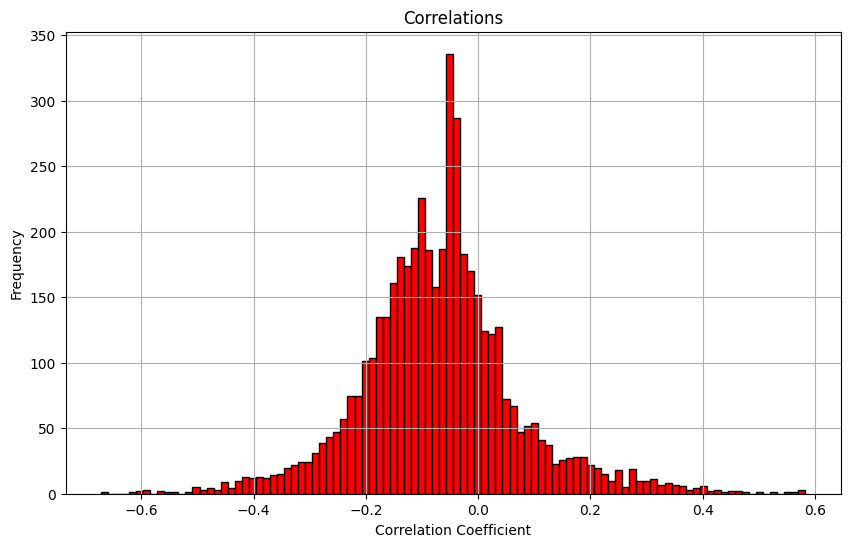

In [13]:
''' Calculating Pearsons coefficient'''

# Always look at data, right?
print(X_aligned.head())

'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Calculate Pearson correlation coefficients
corr_coefficients = [] # Collectes coefficents from X_aligned and Y_aligned calculations

# I should probably check how pearsons actually works
 

for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Fitting 5 folds for each of 189 candidates, totalling 945 fits
Best parameters found: {'estimator': RandomForestClassifier(random_state=42), 'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'select_k__k': 300}
Best cross-validation score: 0.965
Matthews Correlation Coefficient: 0.8540526967895338


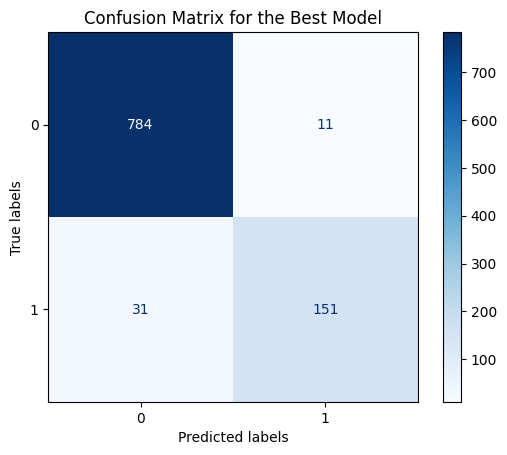

In [14]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]



''' Grid search '''

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)


'''MCC shenanigans'''

mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")


# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for the Best Model')
plt.show()


Most selected COGS terms for predicting oxygen trait in hierchical manner based on randomforest classifier:
This is model based feature importance (uses models own feature importance score to evaluate most important ones)
Index(['COG0276', 'COG0508', 'COG1592', 'COG1845', 'COG0604', 'COG0026',
       'COG0665', 'COG0105', 'COG2033', 'COG1764'],
      dtype='object', name='COG')


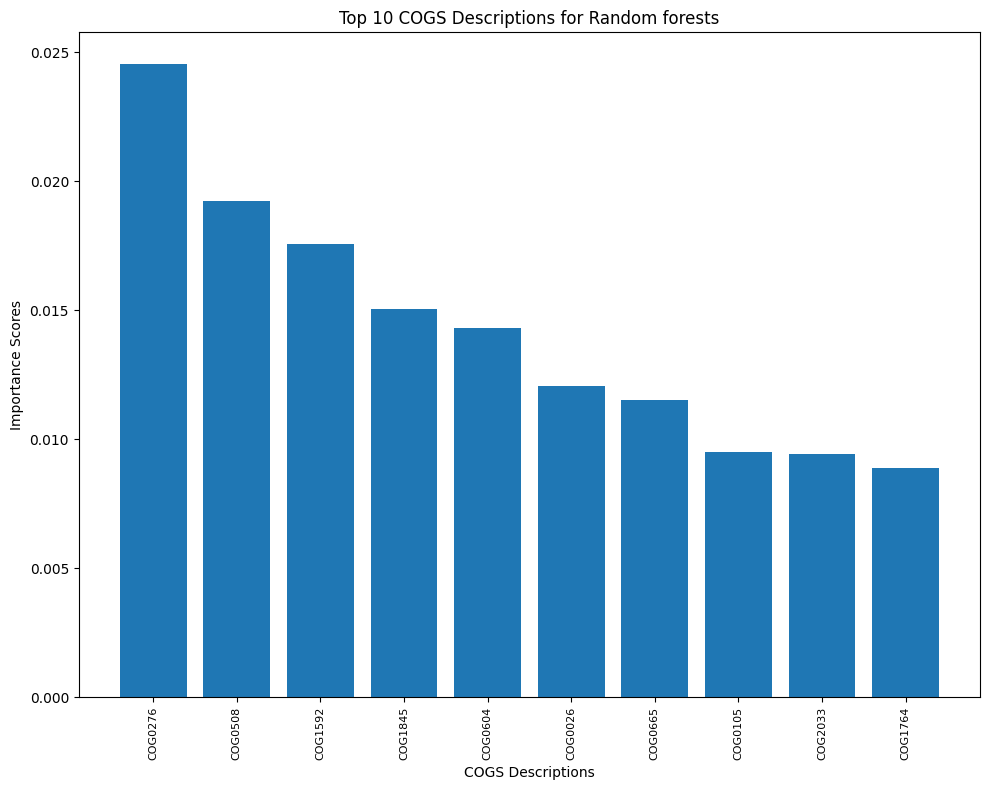

Most selected COGS terms for predicting oxygen trait in hierchical manner based on logistic regression:
This is model based feature importance (uses model's coefficients as importance scores)
Index(['COG2020', 'COG1271', 'COG1454', 'COG3759', 'COG4989', 'COG1874',
       'COG0431', 'COG1832', 'COG3209', 'COG3654'],
      dtype='object', name='COG')


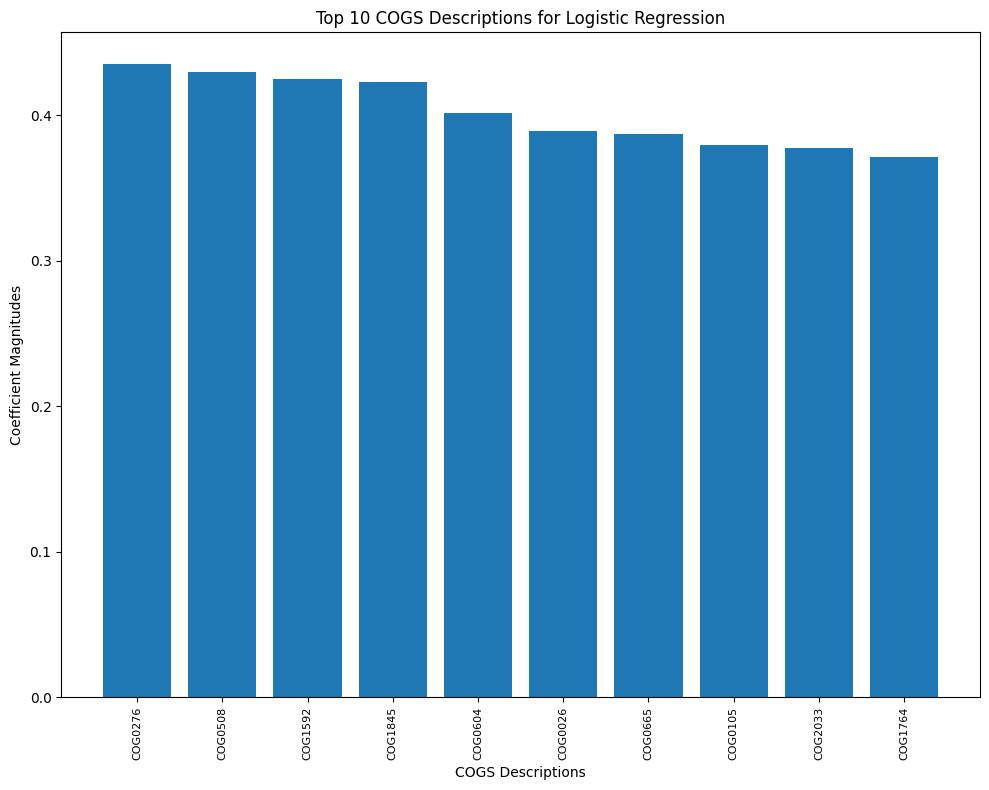

In [15]:
''' Model based feature importance score '''

#Fit a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_aligned, Y_aligned)

#Rank features by their importances
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 10 features
top_k_indices = sorted_indices[:10]
selected_features = X_aligned.columns[top_k_indices]

# Scores of selected features
sorted_scores = feature_importances[top_k_indices]

print("Most selected COGS terms for predicting oxygen trait in hierchical manner based on randomforest classifier:")
print("This is model based feature importance (uses models own feature importance score to evaluate most important ones)")
print(selected_features)

#Translate selected GO terms to their descriptions
# Need to find translation thingy

# Prepare labels and scores for plotting
labels = selected_features
sorted_labels = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels)), sorted_scores)
plt.xticks(range(len(sorted_labels)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('COGS Descriptions')
plt.ylabel('Importance Scores')
plt.title('Top 10 COGS Descriptions for Random forests')
plt.tight_layout()
plt.show()


''' For logsitc regression'''

#Fit a LogisticRegression model
lr_model = LogisticRegression(solver="liblinear")
lr_model.fit(X_aligned, Y_aligned)

#Rank features by their coefficients
lr_coefficients = lr_model.coef_[0]
sorted_indices_lr = np.argsort(np.abs(lr_coefficients))[::-1]

# Select the top 10 features
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

# Coefficients (importance) of selected features
sorted_scores_lr = lr_coefficients[top_k_indices_lr]

print("Most selected COGS terms for predicting oxygen trait in hierchical manner based on logistic regression:")
print("This is model based feature importance (uses model's coefficients as importance scores)")
print(selected_features_lr)


# Prepare labels and scores for plotting
labels_lr = selected_features_lr
sorted_labels_lr = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels_lr)), np.abs(sorted_scores_lr))  # Use absolute value for visualization
plt.xticks(range(len(sorted_labels_lr)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('COGS Descriptions')
plt.ylabel('Coefficient Magnitudes')
plt.title('Top 10 COGS Descriptions for Logistic Regression')
plt.tight_layout()
plt.show()


In [16]:
'''import requests
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Define a function to retrieve GO terms for COGs
def get_go_terms_for_cogs(cog_terms):
    cog_to_go = {}
    for cog in cog_terms:
        try:
            response = requests.get(f"https://eggnogapi5.embl.de/nog_data/json/go_terms/nogname={cog}")
            response.raise_for_status()
            response_data = response.json()
            go_terms = [entry['GO_term'] for entry in response_data] if response_data else []
            cog_to_go[cog] = go_terms
        except Exception as e:
            print(f"Error retrieving GO terms for {cog}: {e}")
            cog_to_go[cog] = []
    return cog_to_go

# Define a function to retrieve pathways for GO terms
def get_pathways_for_go_terms(go_terms):
    go_to_pathway = {}
    for go in go_terms:
        try:
            response = requests.get(f"https://eggnogapi5.embl.de/nog_data/json/pathways/go={go}")
            response.raise_for_status()
            response_data = response.json()
            pathways = [entry['pathway_id'] for entry in response_data] if response_data else []
            go_to_pathway[go] = pathways
        except Exception as e:
            print(f"Error retrieving pathways for GO term {go}: {e}")
            go_to_pathway[go] = []
    return go_to_pathway

selected_important_features = ['COG2020', 'COG1271', 'COG1454']  # Example COG terms

# Step 1: Map COGs to GO terms
cog_to_go = get_go_terms_for_cogs(selected_important_features)

# Flatten the GO terms list for the next step
all_go_terms = {go for go_list in cog_to_go.values() for go in go_list}

# Step 2: Map GO terms to pathways
go_to_pathway = get_pathways_for_go_terms(all_go_terms)

# Combine COG to pathways mapping
cog_to_pathways = {}
for cog, gos in cog_to_go.items():
    pathways = set()
    for go in gos:
        pathways.update(go_to_pathway.get(go, []))
    cog_to_pathways[cog] = list(pathways)

# Creating the adjacency matrix
pathway_matrix = pd.DataFrame(
    index=selected_important_features,
    columns=set(pw for pw_list in cog_to_pathways.values() for pw in pw_list),
    data=0
)
for cog, pathways in cog_to_pathways.items():
    for pathway in pathways:
        pathway_matrix.loc[cog, pathway] = 1

print("Pathway matrix:\n", pathway_matrix)

# Initialize a network graph
G = nx.Graph()

# Add nodes and edges
for cog in selected_important_features:
    G.add_node(cog, title=cog, label=cog, color='red', size=20)

for pathway in pathway_matrix.columns:
    G.add_node(pathway, title=pathway, label=pathway, color='blue', size=30)
    for cog in pathway_matrix.index:
        if pathway_matrix.loc[cog, pathway] == 1:
            G.add_edge(cog, pathway)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading='Interactive Network of COG Terms and Pathways', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])

nt.save_graph("cog_network.html")
'''

Error retrieving GO terms for COG2020: HTTPSConnectionPool(host='eggnogapi5.embl.de', port=443): Max retries exceeded with url: /nog_data/json/go_terms/nogname=COG2020 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000224D80BAB10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
Error retrieving GO terms for COG1271: HTTPSConnectionPool(host='eggnogapi5.embl.de', port=443): Max retries exceeded with url: /nog_data/json/go_terms/nogname=COG1271 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000224D8012B10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
Error retrieving GO terms for COG1454: HTTPSConnectionPool(host='eggnogapi5.embl.de', port=443): Max retries exceeded with url: /nog_data/json/go_terms/nogname=COG1454 (Caused by NewConnectionError('<ur

ValueError: columns cannot be a set

In [17]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 0    1909
1     370
Name: count, dtype: int64
Unique labels in Y_train: [0 1]
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279


Processing estimator: RandomForestClassifier
Testing with k=1
Testing with k=21
Testing with k=41
Testing with k=61
Testing with k=81
Testing with k=101
Testing with k=121
Testing with k=141
Testing with k=161
Testing with k=181
Testing with k=201
Testing with k=221
Testing with k=241
Testing with k=261
Testing with k=281
Testing with k=301
Testing with k=321
Testing with k=341
Testing with k=361
Testing with k=381
Testing with k=401
Testing with k=421
Testing with k=441
Testing with k=461
Testing with k=481
Testing with k=501
Testing with k=521
Testing with k=541
Testing with k=561
Testing with k=581
Testing with k=601
Testing with k=621
Testing with k=641
Testing with k=661
Testing with k=681
Testing with k=701
Testing with k=721
Testing with k=741
Testing with k=761
Testing with k=781
Testing with k=801
Testing with k=821
Testing with k=841
Testing with k=861
Testing with k=881
Testing with k=901
Testing with k=921
Testing with k=941
Testing with k=961
Testing with k=981
Processing 

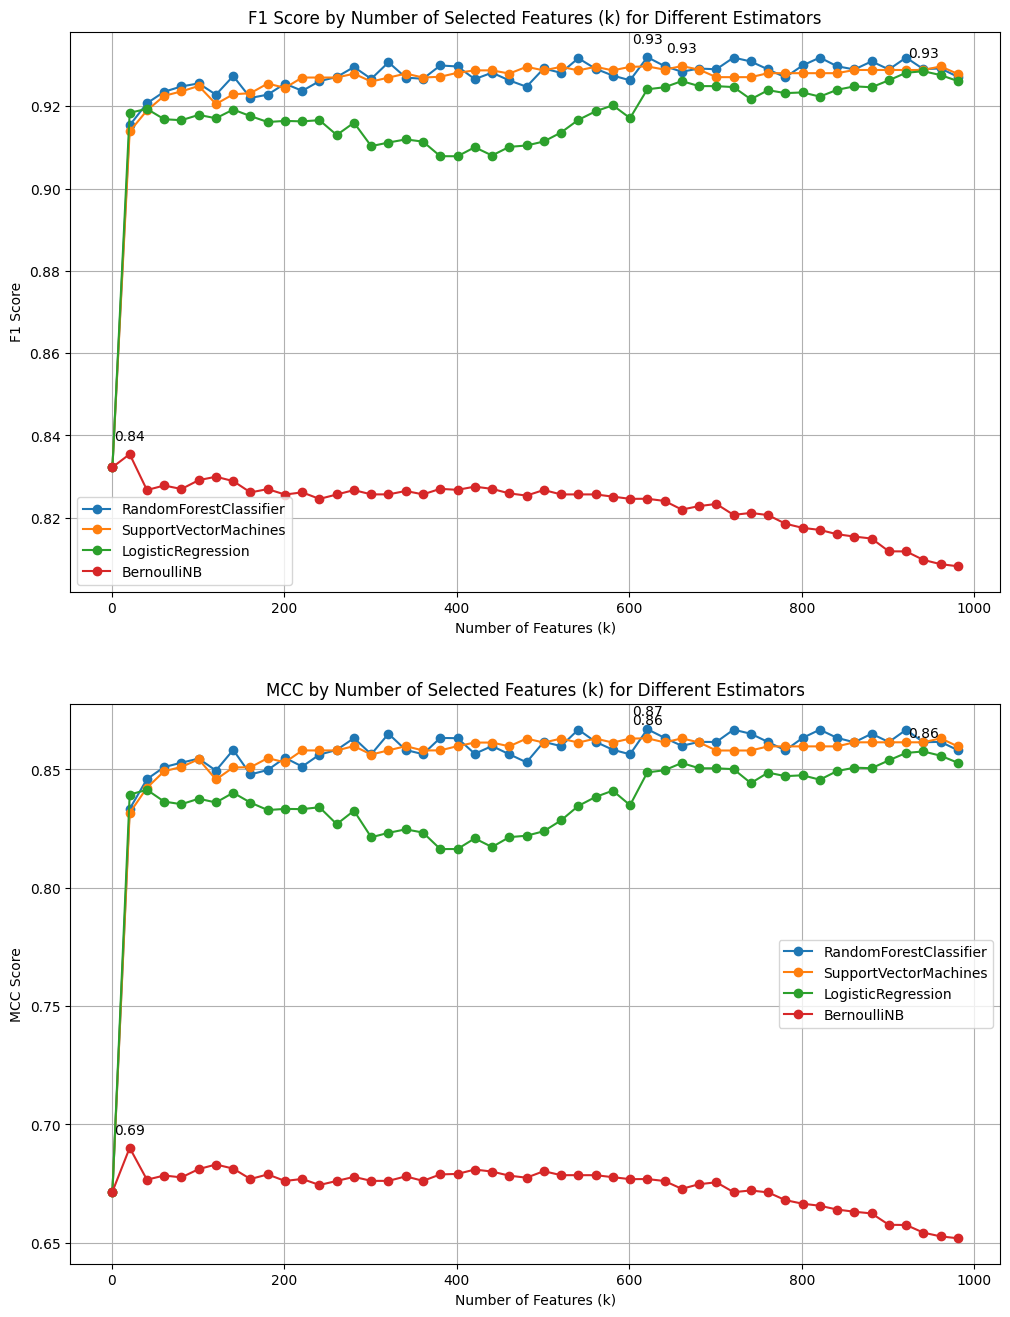

In [18]:
''' Comparing F1 and MCC plots'''

# Define the range of `k` values to explore
k_values = range(1, 1000, 20)  # Range of steps

# Define estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store results for both F1 and MCC
results = {name: {'f1': [], 'mcc': []} for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")  # Debug print
    # Loop over each `k` value
    for k in k_values:
        print(f"Testing with k={k}")  # Debug print
        # Define the pipeline for the current estimator
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        
        # Perform cross-validation for F1-score
        f1_scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)
        results[name]['f1'].append(f1_scores.mean())
        
        # Perform cross-validation for MCC
        mcc_scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, scoring=make_scorer(matthews_corrcoef), n_jobs=-1)
        results[name]['mcc'].append(mcc_scores.mean())

# For debugging 
print(results)

''' Plotting '''

# Plotting the results for each estimator for both F1 and MCC
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

for name, scores in results.items():
    k_values_list = list(k_values)  # Convert range to list for indexing
    # F1 Plot
    finite_f1_scores = [score for score in scores['f1'] if np.isfinite(score)]
    finite_k_values_f1 = [k for k, score in zip(k_values_list, scores['f1']) if np.isfinite(score)]
    ax[0].plot(finite_k_values_f1, finite_f1_scores, marker='o', linestyle='-', label=name)
    
    # highest F1 score
    if finite_f1_scores:  # Check if there are any finite scores
        max_f1_score = max(finite_f1_scores)
        max_f1_index = finite_f1_scores.index(max_f1_score)
        best_k_f1 = finite_k_values_f1[max_f1_index]
        ax[0].annotate(f'{max_f1_score:.2f}', (best_k_f1, max_f1_score), textcoords="offset points", xytext=(0,10), ha='center')
    
    # MCC Plot
    finite_mcc_scores = [score for score in scores['mcc'] if np.isfinite(score)]
    finite_k_values_mcc = [k for k, score in zip(k_values_list, scores['mcc']) if np.isfinite(score)]
    ax[1].plot(finite_k_values_mcc, finite_mcc_scores, marker='o', linestyle='-', label=name)

    #  highest MCC score
    if finite_mcc_scores:  # Check if there are any finite scores
        max_mcc_score = max(finite_mcc_scores)
        max_mcc_index = finite_mcc_scores.index(max_mcc_score)
        best_k_mcc = finite_k_values_mcc[max_mcc_index]
        ax[1].annotate(f'{max_mcc_score:.2f}', (best_k_mcc, max_mcc_score), textcoords="offset points", xytext=(0,10), ha='center')

    

ax[0].set_title('F1 Score by Number of Selected Features (k) for Different Estimators')
ax[0].set_xlabel('Number of Features (k)')
ax[0].set_ylabel('F1 Score')

ax[1].set_title('MCC by Number of Selected Features (k) for Different Estimators')
ax[1].set_xlabel('Number of Features (k)')
ax[1].set_ylabel('MCC Score')

for a in ax:
    a.legend()
    a.grid(True)

#plt.tight_layout()
plt.show()

Pearson Correlation Coefficient: 0.154


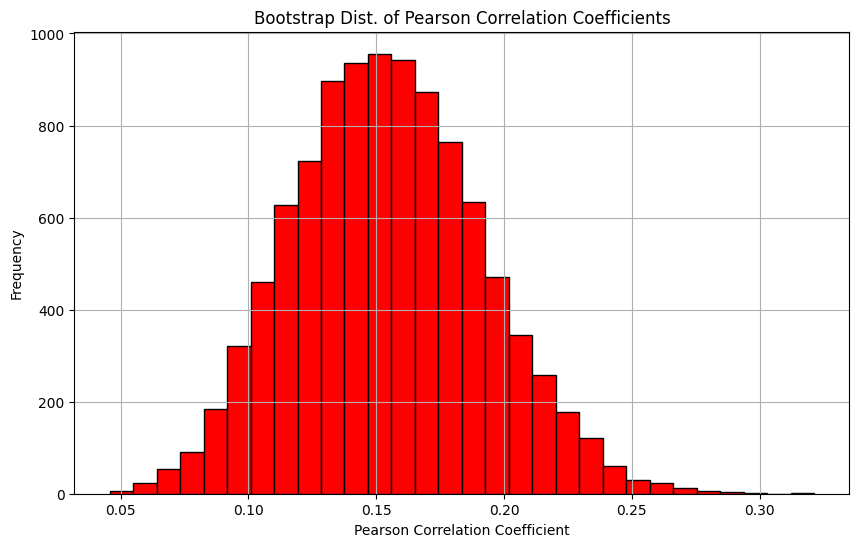

In [40]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''


lr_model = LogisticRegression(solver='liblinear', penalty="l1")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")


# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()